In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
stat = pd.read_csv('../keyhistory.csv') # data to read
stat["time"] = (pd.to_datetime(stat["time"], unit = 's'))

In [ ]:
pd.set_option('display.max_rows', 10)

In [ ]:
# TODO:
#
# интегральный график того сколько раз нажимал кнопку каждую
# типа например кнопка А - 8 числа 500 нажатий, затем 9 числа еще 500 нажатий, 
# на графике 8 числа - 500, 9 числа - 1к
# ------------------------------------
# логгинг мыши с перспективой получения heatmap кликов 

In [3]:
def AllTimeStrokes():
    """клавиши и соответствующее им количество нажатий за все время"""
    # аналогично stat.groupby(by='key').size()
    # topN значений - head(N), что такое tail(N) понятно
    return stat.key.value_counts()

def GetKeyLog(key):
    """получить нажатия определенной клавиши за всё время"""
    if key not in stat.key.drop_duplicates().tolist():
        return 0
    return stat.groupby(by='key').get_group(key)

def SplitStrokes(scale = "d", data = stat, allowEmpty = True):
    """число нажатий за всё время, разбитое на промежутки, данные в аргументе scale
    может считать нажатия отдельно взятой клавиши, см. аргумент data
    может убирать пустые вхождения, см. аргумент allowEmpty"""
    resampled = data.resample(scale, on='time').size()
    if (not allowEmpty):
        return resampled[resampled != 0]
    return resampled

def Average(period):
    """среднее число нажатий за данный период"""
    return period.mean()

def InPeriod(data, start, offset):
    """ограничить интервал данных промежутком от старта до старта+оффсета"""
    # объяснение, зачем обрезать последнюю запись: 
    # 01:00 соответствует интервалу с 01:00 до 02:00, тогда если мы претендуем
    # дать данные за 2 часа, и мы начинаем с 3 часов ночи то мы должны давать 
    # записи 03:00 и 04:00 (это будет интервал 03:00-04:00 и 04:00-05:00, т.е 2 часа)
    # но пандас по умолчанию при индексировании включает как первую, так и последнюю
    # запись. то есть, взяв 03:00 и 2 hours, мы бы получили записи 03:00, 04:00 и 05:00
    # а это уже не 2 часа, а 3
    start_date = pd.Timestamp(start)
    end_date = start_date + pd.Timedelta(offset)
    return data[start_date : end_date].iloc[:-1] # обрезаем последнюю запись

def PiePlot():
    """Представить данные нажатий за всё время в виде pie-чарта"""
    # получаем данные для визуализации
    indexes = AllTimeStrokes().index.to_numpy()
    values = AllTimeStrokes().to_numpy()
    
    # прячем лишние элементы в other, что бы суммарно было 20 элементов + other
    other_values = values[20:len(values)]
    values = np.delete(values, range(20, len(values)))
    values = np.append(values, other_values.sum())
    indexes = np.delete(indexes, range(20, len(indexes)))
    indexes = np.append(indexes, "Other")
    
    percent = 100.*values/values.sum()
    patches, texts = plt.pie(values, startangle=90, radius=2, 
                             colors = ['#e6194B', '#f58231', '#ffe119', '#bfef45',
                                       '#3cb44b', '#42d4f4', '#4363d8', '#911eb4', '#f032e6',
                                       '#fabed4', '#ffd8b1', '#fffac8', '#aaffc3', '#dcbeff',
                                       'lightcyan', 'lightblue', 'lightpink', 'beige', 
                                       'lightsteelblue', 'slategrey', '#a9a9a9'])
    
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(indexes, percent)]
    plt.legend(patches, labels, loc='center right', bbox_to_anchor=(2.2, 0.5),
               fontsize=11)
    plt.show()

In [4]:
print("Среднее число нажатий любых клавиш в час за всё время:",
      Average(SplitStrokes("h")))
print("Среднее число нажатий клавиши A в час за всё время:",
     Average(SplitStrokes('h', GetKeyLog("A"))))
print("Число нажатий клавиши A, разбитое на промежутки по часу:\n",
     SplitStrokes('h', GetKeyLog("A")), "\n")
print("Число нажатий клавиши A, разбитое по часам и без пустых интервалов:\n",
     SplitStrokes('h', GetKeyLog("A"), False), "\n")
print("Среднее число нажатий любых клавиш за 2 часа 12/08/20 между 11 и 13 часами:",
     Average(InPeriod(SplitStrokes('h'), "2020-08-12 11:00:00", "2 hours")))

Среднее число нажатий любых клавиш в час за всё время: 2539.0
Среднее число нажатий клавиши A в час за всё время: 75.16666666666667
Число нажатий клавиши A, разбитое на промежутки по часу:
 time
2020-08-12 10:00:00      3
2020-08-12 11:00:00      0
2020-08-12 12:00:00     62
2020-08-12 13:00:00    152
2020-08-12 14:00:00    190
2020-08-12 15:00:00     44
Freq: H, dtype: int64 

Число нажатий клавиши A, разбитое по часам и без пустых интервалов:
 time
2020-08-12 10:00:00      3
2020-08-12 12:00:00     62
2020-08-12 13:00:00    152
2020-08-12 14:00:00    190
2020-08-12 15:00:00     44
dtype: int64 

Среднее число нажатий любых клавиш за 2 часа 12/08/20 между 11 и 13 часами: 967.0


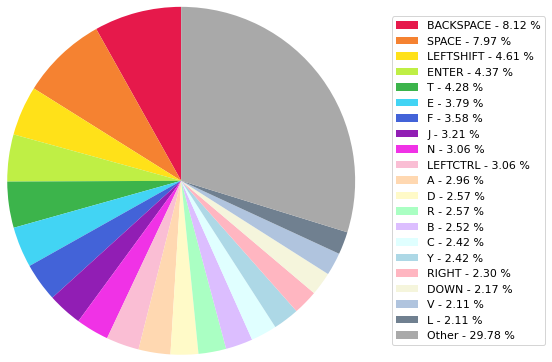

In [5]:
PiePlot()